# 유전체 정보 품종 분류 AI 경진대회
**[배경]**<br>
개체 정보와 SNP 정보를 이용하여 A, B, C 품종을 분류하는 최고의 품종구분 정확도를 획득하는 것이 목표이다.

**[주제]**<br>
개체와 SNP 정보를 이용하여 품종 분류 AI 모델 개발

**[주최 / 주관]**<br>
- 주최 : 충남대학교, 티엔티리써치, AI Frenz
- 주관 : 데이콘

**[평가 방식]**
- 평가 산식 : Macro F1 Score
- Private Score 상위 10팀 코드 및 PPT 제출 후 코드 평가

**[규칙]**
- 외부 데이터 사용 금지
- 사용에 법적 제약이 없으며 **논문으로 공개된 사전 학습 모델(Pre-trained Model) 사용 가능**
    - 사전 학습 모델의 출처와 논문 링크 필수 기재
    - 단, Test dataset이 포함된 데이터로 사전 학습된 모델 사용 불가능

## Dataset Info
**train.csv [파일]**
- id : 개체 고유 ID
- 개체정보
    - father : 개체의 가계 고유 번호 (0 : Unknown)
    - mother : 개체의 모계 고유 번호 (0 : Unknown)
    - gender : 개체 성별 (0 : Unknown, 1 : female, 2 : male)
    - trait : 개체 표현형 정보 
- 15개의 SNP 정보 : SNP_01 ~ SNP_15
- class : 개체의 품종 (A,B,C)

**test.csv [파일]**
- id : 개체 샘플 별 고유 ID
- 개체정보
    - father : 개체의 가계 고유 번호 (0 : Unknown)
    - mother : 개체의 모계 고유 번호 (0 : Unknown)
    - gender : 개체 성별 (0 : Unknown, 1 : female, 2 : male)
    - trait : 개체 표현형 정보 
- 15개의 SNP 정보 : SNP_01 ~ SNP_15

**snp_info.csv [파일]**
- 15개의 SNP 세부 정보
- name : SNP 명
- chrom : 염색체 정보
- cm : Genetic distance
- pos : 각 마커의 유전체상 위치 정보

**sample_submission.csv [파일] - 제출 양식**
- id : 개체 샘플 별 고유 ID
- class : 예측한 개체의 품종 (A,B,C)

## Version

In [1]:
import platform
platform.platform()

'Linux-5.10.147+-x86_64-with-glibc2.29'

In [2]:
!cat /etc/issue.net

Ubuntu 20.04.5 LTS


In [3]:
!python --version

Python 3.8.10


## Import & Install

In [5]:
# 코랩 기준 필요 라이브러리 설치

# Category_encoders 설치
!pip install category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.2/81.2 KB 4.2 MB/s eta 0:00:00


In [7]:
# Base & visualization
import pandas as pd
import random
import os
import numpy as np
import warnings
import matplotlib.pylab as plt
import seaborn as sns

# sklearn module & utils
from tqdm.notebook import tqdm
from sklearn.feature_selection import SelectPercentile
from sklearn.model_selection import StratifiedKFold , KFold, train_test_split, cross_val_score, cross_validate
warnings.filterwarnings('ignore') 

# Scaling
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Encoding
import category_encoders as ce

# Sampling
from imblearn.over_sampling import BorderlineSMOTE

# Modeling
from sklearn.ensemble import BaggingClassifier, GradientBoostingClassifier, VotingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import RidgeClassifier, RidgeClassifierCV
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

## Fix Seed

In [8]:
#Seed 고정
class CFG:
    SEED = 26

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(CFG.SEED) # Seed 고정

## Data Load

In [10]:
DATA_PATH = '/content/'

In [25]:
train = pd.read_csv(DATA_PATH + 'train.csv')
test = pd.read_csv(DATA_PATH + 'test.csv')
snp = pd.read_csv(DATA_PATH + 'snp_info.csv')

## EDA

In [26]:
print(train.shape)
train.head()

(262, 21)


,id,father,mother,gender,trait,SNP_01,SNP_02,SNP_03,SNP_04,SNP_05,...,SNP_07,SNP_08,SNP_09,SNP_10,SNP_11,SNP_12,SNP_13,SNP_14,SNP_15,class
0,TRAIN_000,0,0,0,2,G G,A G,A A,G A,C A,...,A A,G G,A A,G G,A G,A A,A A,A A,A A,B
1,TRAIN_001,0,0,0,2,A G,A G,C A,A A,A A,...,A A,G A,A A,A G,A A,G A,G G,A A,A A,C
2,TRAIN_002,0,0,0,2,G G,G G,A A,G A,C C,...,A A,G A,G A,A G,A A,A A,A A,A A,A A,B
3,TRAIN_003,0,0,0,1,A A,G G,A A,G A,A A,...,G G,A A,G G,A G,G G,G G,G G,A A,G G,A
4,TRAIN_004,0,0,0,2,G G,G G,C C,A A,C C,...,A A,A A,A A,G G,A A,A A,A G,A A,G A,C


In [27]:
# SNP_01 ~ SNP_15
snp_col = train.columns[train.columns.str.contains('SNP')].tolist()

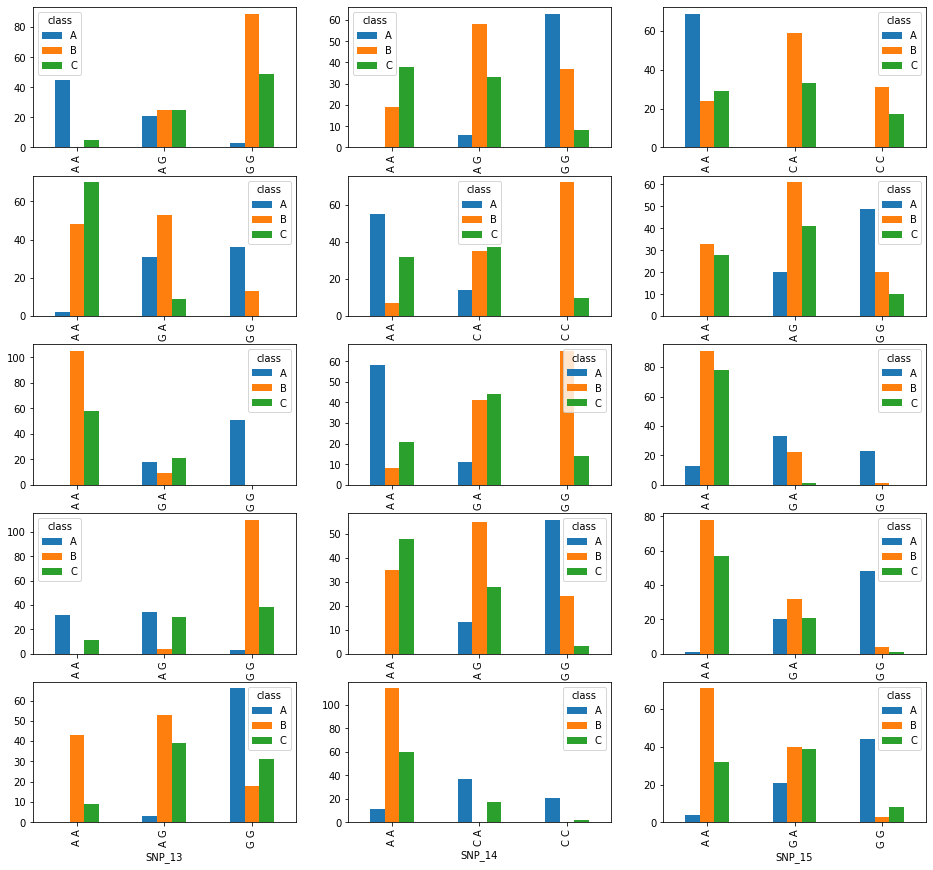

In [28]:
# SNP_01 ~ SNP_15별 class 개수
fig, ax = plt.subplots(5, 3, figsize=(16, 15))
idx = 0
for col in snp_col:
    train.groupby(col)['class'].value_counts().unstack().plot.bar(ax=ax[idx//3, idx%3])
    idx += 1
plt.show()

In [29]:
#X Y 데이터분리 및 id column drop
def get_x_y(df):
    if 'class' in df.columns:
        df_x = df.drop(columns=['id', 'class'])
        df_y = df['class']
        return df_x, df_y
    else:
        df_x = df.drop(columns=['id'])
        return df_x

train_x, train_y = get_x_y(train)
test_x = get_x_y(test)

In [30]:
# target변수 다중분류(A, B, C)
train_y.unique().tolist()

['B', 'C', 'A']

In [31]:
train_y.value_counts()

B    114
C     79
A     69
Name: class, dtype: int64

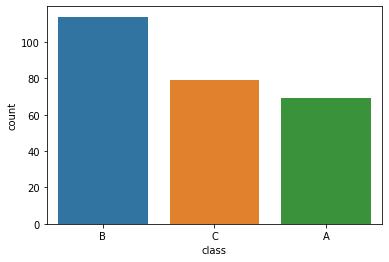

In [32]:
_ = sns.countplot(train_y)

In [33]:
# father, mother, gender에는 0으로만 입력되어 있음
print(train['father'].unique().tolist())
print(train['mother'].unique().tolist())
print(train['gender'].unique().tolist())
print(train['trait'].unique().tolist())

[0]
[0]
[0]
[2, 1]


## Data Pre-processing

In [34]:
# 동일한 값을 가지는 columns 제거 -> 모델링에 좋지 않은 영향을 줄 것으로 판단 
train_x = train_x.drop(columns=['father','mother','gender'])
test_x = test_x.drop(columns=['father','mother','gender'])

## Feature Engineering

SNP 정보(name, chrom, cm, pos)를 활용하여 Feature Engineering을 진행한다.

- name(SNP 명) & chrom(염색체 정보)
- chrom(염색체 정보)
- SNP Total combination
- cm(Genetic distance)
- SNP G,C,A mathematical feature

In [35]:
snp

,SNP_id,name,chrom,cm,pos
0,SNP_01,BTA-19852-no-rs,2,67.05460,42986890
1,SNP_02,ARS-USMARC-Parent-DQ647190-rs29013632,6,31.15670,13897068
2,SNP_03,ARS-BFGL-NGS-117009,6,68.28920,44649549
3,SNP_04,ARS-BFGL-NGS-60567,6,77.87490,53826064
4,SNP_05,BovineHD0600017032,6,80.50150,61779512
5,SNP_06,BovineHD0600017424,6,80.59540,63048481
6,SNP_07,Hapmap49442-BTA-111073,6,80.78000,64037334
7,SNP_08,BovineHD0600018638,6,82.68560,67510588
8,SNP_09,ARS-BFGL-NGS-37727,6,86.87400,73092782
9,SNP_10,BTB-01558306,7,62.06920,40827112


### SNP 합

In [40]:
train_x['2_BTA'] = train_x['SNP_01']
train_x['chrom_6'] = train_x['SNP_02'] + '-' + train_x['SNP_03'] + '-' + train_x['SNP_04'] + '-' + train_x['SNP_05'] + '-' + train_x['SNP_06'] + '-' + train_x['SNP_07'] + '-' + train_x['SNP_08'] + '-' + train_x['SNP_09']
train_x['6_ARS_Parent'] = train_x['SNP_02']
train_x['6_ARS_BFGL'] = train_x['SNP_03'] + '-' + train_x['SNP_04'] + '-' + train_x['SNP_09']
train_x['6_BOVINE'] = train_x['SNP_05'] + '-' + train_x['SNP_06'] + '-' + train_x['SNP_08']
train_x['6_HAPMAP'] = train_x['SNP_07']
train_x['7_BTB'] = train_x['SNP_10']
train_x['8_ARS'] = train_x['SNP_11']
train_x['chrom_9'] = train_x['SNP_12'] + '-' + train_x['SNP_13'] + '-' + train_x['SNP_14']
train_x['9_HAPMAP'] = train_x['SNP_12'] + '-' + train_x['SNP_14']
train_x['9_BTB'] = train_x['SNP_13']
train_x['10_BOVINE'] = train_x['SNP_15']
train_x['SNP_total'] = train_x['SNP_01'] + '-' + train_x['SNP_02'] + '-' + train_x['SNP_03'] + '-' + train_x['SNP_04'] + '-' + train_x['SNP_05'] + '-' + train_x['SNP_06'] + '-' + train_x['SNP_07'] + '-' + train_x['SNP_08'] + '-' + train_x['SNP_09'] + '-' + train_x['SNP_10'] + '-' + train_x['SNP_11'] + '-' + train_x['SNP_12'] + '-' + train_x['SNP_13'] + '-' + train_x['SNP_14'] + '-' + train_x['SNP_15']  

In [41]:
test_x['2_BTA'] = test_x['SNP_01']
test_x['chrom_6'] = test_x['SNP_02'] + '-' + test_x['SNP_03'] + '-' + test_x['SNP_04'] + '-' + test_x['SNP_05'] + '-' + test_x['SNP_06'] + '-' + test_x['SNP_07'] + '-' + test_x['SNP_08'] + '-' + test_x['SNP_09']
test_x['6_ARS_Parent'] = test_x['SNP_02']
test_x['6_ARS_BFGL'] = test_x['SNP_03'] + '-' + test_x['SNP_04'] + '-' + test_x['SNP_09']
test_x['6_BOVINE'] = test_x['SNP_05'] + '-' + test_x['SNP_06'] + '-' + test_x['SNP_08']
test_x['6_HAPMAP'] = test_x['SNP_07']
test_x['7_BTB'] = test_x['SNP_10']
test_x['8_ARS'] = test_x['SNP_11']
test_x['chrom_9'] = test_x['SNP_12'] + '-' + test_x['SNP_13'] + '-' + test_x['SNP_14']
test_x['9_HAPMAP'] = test_x['SNP_12'] + '-' + test_x['SNP_14']
test_x['9_BTB'] = test_x['SNP_13']
test_x['10_BOVINE'] = test_x['SNP_15']
test_x['SNP_total'] = test_x['SNP_01'] + '-' + test_x['SNP_02'] + '-' + test_x['SNP_03'] + '-' + test_x['SNP_04'] + '-' + test_x['SNP_05'] + '-' + test_x['SNP_06'] + '-' + test_x['SNP_07'] + '-' + test_x['SNP_08'] + '-' + test_x['SNP_09'] + '-' + test_x['SNP_10'] + '-' + test_x['SNP_11'] + '-' + test_x['SNP_12'] + '-' + test_x['SNP_13'] + '-' + test_x['SNP_14'] + '-' + test_x['SNP_15'] 

### 공백 제거

In [42]:
# 공백을 제거해주는 함수
def blank(data_tr, data_te, columns):
    for i in columns:
        data_tr[i] = data_tr[i].apply(lambda x : x.replace(" ", ""))
        data_te[i] = data_te[i].apply(lambda x : x.replace(" ", ""))
    return data_tr, data_te

In [49]:
columns = train_x.iloc[:,16:].columns.to_list()
train_x.iloc[:, 16:], test_x.iloc[:, 16:] = blank(train_x.iloc[:,16:], test_x.iloc[:,16:], columns)

### SNP A,C,G 값 개수

In [59]:
train_x['concat'] = train_x.iloc[:,1:16].sum(axis=1).apply(lambda x : x.replace(" ",""))
train_x['numGC'] = train_x['concat'].apply(lambda x : x.count('C') + x.count('G'))
train_x['numA'] = train_x['concat'].apply(lambda x : x.count('A'))
train_x['numGC^2'] = train_x['numGC']**2
train_x['sub'] = train_x['numGC'] - train_x['numA']
train_x['H'] = train_x['numGC']*3 + train_x['numA']*2

In [60]:
test_x['concat'] = test_x.iloc[:,1:16].sum(axis=1).apply(lambda x : x.replace(" ",""))
test_x['numGC'] = test_x['concat'].apply(lambda x : x.count('C')+x.count('G'))
test_x['numA'] = test_x['concat'].apply(lambda x : x.count('A'))
test_x['numGC^2'] = test_x['numGC']**2
test_x['sub'] = test_x['numGC'] - test_x['numA']
test_x['H'] = test_x['numGC']*3 + test_x['numA']*2

### trait 변수 type 변환

In [61]:
train_x['trait'] = train_x['trait'].astype('object')
test_x['trait'] = test_x['trait'].astype('object')

### 범주형, 수치형 피처 구분

In [64]:
cat_features = train_x.select_dtypes(include=['object']).columns.to_list()
num_features = train_x.select_dtypes(exclude=['object']).columns.to_list()

## Scaling

In [65]:
scaler = StandardScaler()
train_x[num_features] = scaler.fit_transform(train_x[num_features])
test_x[num_features] = scaler.transform(test_x[num_features])

## Encoding
https://contrib.scikit-learn.org/category_encoders/

In [83]:
def catboost_encoder_multiclass(X,X_t,y):
    y = y.astype(str)
    enc = ce.OneHotEncoder().fit(y)  # category_encoders 사용하여 fit
    y_onehot = enc.transform(y)  # target 범주 수만큼의 컬럼을 가진 0, 1로 변환된 DataFrame 형태
    class_names = y_onehot.columns  # ['class_1', 'class_2', 'class_3']
    X_obj = X.select_dtypes('object')  # X_train 범주형
    X_t_obj = X_t.select_dtypes('object')  # X_test 범주형
    X = X.select_dtypes(exclude='object')  # X_train 수치형
    X_t = X_t.select_dtypes(exclude='object')   # X_test 수치형

    for class_ in class_names:  # class_1, class_2, class_3
        enc = ce.CatBoostEncoder()
        enc.fit(X_obj, y_onehot[class_])
        temp = enc.transform(X_obj)  # 각 컬럼당 각 class_에 대한 컬럼이 생성된 DataFrame 형태 -> value는 수치형
        temp_t = enc.transform(X_t_obj)
        temp.columns = [str(x)+'_'+str(class_) for x in temp.columns]
        temp_t.columns = [str(x)+'_'+str(class_) for x in temp_t.columns]
        X = pd.concat([X,temp],axis=1)  # 수치형 X와 encoding한 temp를 병합
        X_t = pd.concat([X_t,temp_t],axis=1)

    return X, X_t

In [84]:
train_x, test_x = catboost_encoder_multiclass(train_x,test_x,train_y)

In [85]:
train_x.head()

,numGC,numA,numGC^2,sub,H,trait_class_1,SNP_01_class_1,SNP_02_class_1,SNP_03_class_1,SNP_04_class_1,...,6_BOVINE_class_3,6_HAPMAP_class_3,7_BTB_class_3,8_ARS_class_3,chrom_9_class_3,9_HAPMAP_class_3,9_BTB_class_3,10_BOVINE_class_3,SNP_total_class_3,concat_class_3
0,-0.986104,0.986104,-0.980678,-0.986104,-0.986104,0.589872,0.629825,0.596277,0.198659,0.568459,...,0.052672,0.001606,0.021469,0.136736,0.007118,0.010441,0.004969,0.039476,0.263359,0.263359
1,-1.270327,1.270327,-1.179312,-1.270327,-1.270327,0.589872,0.353265,0.596277,0.639087,0.400290,...,0.107779,0.001606,0.496570,0.003135,0.191962,0.060433,0.571236,0.039476,0.263359,0.263359
2,-0.417657,0.417657,-0.520685,-0.417657,-0.417657,0.589872,0.629825,0.343441,0.198659,0.568459,...,0.043893,0.001606,0.496570,0.003135,0.007118,0.010441,0.004969,0.039476,0.263359,0.263359
3,1.287685,-1.287685,1.361107,1.287685,1.287685,0.006216,0.008532,0.343441,0.198659,0.568459,...,0.934842,0.985834,0.496570,0.669802,0.726336,0.558720,0.571236,0.790417,0.754453,0.754453
4,-0.417657,0.417657,-0.520685,-0.417657,-0.417657,0.589872,0.629825,0.343441,0.641533,0.400290,...,0.043893,0.001606,0.021469,0.003135,0.004788,0.010441,0.033993,0.210528,0.263359,0.263359


In [86]:
test_x.head()

,numGC,numA,numGC^2,sub,H,trait_class_1,SNP_01_class_1,SNP_02_class_1,SNP_03_class_1,SNP_04_class_1,...,6_BOVINE_class_3,6_HAPMAP_class_3,7_BTB_class_3,8_ARS_class_3,chrom_9_class_3,9_HAPMAP_class_3,9_BTB_class_3,10_BOVINE_class_3,SNP_total_class_3,concat_class_3
0,0.719237,-0.719237,0.650208,0.719237,0.719237,0.006216,0.353265,0.343441,0.198659,0.568459,...,0.107779,0.985834,0.496570,0.136736,0.891460,0.803335,0.571236,0.210528,0.263359,0.263359
1,-0.417657,0.417657,-0.520685,-0.417657,-0.417657,0.589872,0.629825,0.596277,0.641533,0.268702,...,0.043893,0.001606,0.021469,0.136736,0.007118,0.010441,0.004969,0.039476,0.263359,0.263359
2,-0.701880,0.701880,-0.761136,-0.701880,-0.701880,0.589872,0.629825,0.596277,0.198659,0.400290,...,0.536350,0.001606,0.496570,0.003135,0.191962,0.060433,0.571236,0.790417,0.263359,0.263359
3,-0.986104,0.986104,-0.980678,-0.986104,-0.986104,0.589872,0.629825,0.596277,0.639087,0.400290,...,0.043893,0.001606,0.021469,0.003135,0.010129,0.060433,0.033993,0.039476,0.263359,0.263359
4,1.287685,-1.287685,1.361107,1.287685,1.287685,0.006216,0.008532,0.343441,0.198659,0.268702,...,0.934842,0.985834,0.496570,0.669802,0.191962,0.060433,0.571236,0.790417,0.263359,0.263359


## SMOTE

In [87]:
# Class 불균형 문제 해결
train_x, train_y = BorderlineSMOTE(random_state=CFG.SEED).fit_resample(train_x, train_y)

## Target Label-Encoding

In [88]:
class_le = LabelEncoder()
train_y = class_le.fit_transform(train_y)

## Modeling & Ensemble

In [89]:
# Submission file 준비
submit = pd.read_csv(DATA_PATH  + 'sample_submission.csv')

In [90]:
# Model Selection -> 여러 모델링 실험결과 종류가 다른 모델 여러개를 앙상블 하는 것이 좋다 판단함
models = [
    ('bag', BaggingClassifier(random_state=CFG.SEED)),
    ('dt', DecisionTreeClassifier(random_state=CFG.SEED)),
    ('rc', RidgeClassifier(random_state=CFG.SEED)),
    ('xgb', XGBClassifier(random_state=CFG.SEED)),
    ('lgb', LGBMClassifier(random_state=CFG.SEED)),
    ('gb', GradientBoostingClassifier(random_state=CFG.SEED)),
    ('svc', SVC(random_state=CFG.SEED)),
    ('rcc', RidgeClassifierCV()),
    ('rf', RandomForestClassifier(random_state=CFG.SEED))
]

In [91]:
# 최종모델은 Votingclassifier 사용하여 ensemble -> 제출결과 public score기준 XGBClassifier와 RandomForestClassifier 성능이 좋아 가중치를 주었음
best_model  = VotingClassifier(models, voting='hard', weights=[1,1,1,2,1,1,1,1,2])
best_model.fit(train_x,train_y)

VotingClassifier(estimators=[('bag', BaggingClassifier(random_state=26)),
                             ('dt', DecisionTreeClassifier(random_state=26)),
                             ('rc', RidgeClassifier(random_state=26)),
                             ('xgb', XGBClassifier(random_state=26)),
                             ('lgb', LGBMClassifier(random_state=26)),
                             ('gb',
                              GradientBoostingClassifier(random_state=26)),
                             ('svc', SVC(random_state=26)),
                             ('rcc',
                              RidgeClassifierCV(alphas=array([ 0.1,  1. , 10. ]))),
                             ('rf', RandomForestClassifier(random_state=26))],
                 weights=[1, 1, 1, 2, 1, 1, 1, 1, 2])

In [93]:
# test predict
pred = class_le.inverse_transform(best_model.predict(test_x))
submit['class'] = pred

In [94]:
submit

,id,class
0,TEST_000,A
1,TEST_001,B
2,TEST_002,C
3,TEST_003,C
4,TEST_004,A
...,...,...
170,TEST_170,B
171,TEST_171,C
172,TEST_172,C
173,TEST_173,B


In [95]:
submit.to_csv('submit.csv',index=False)